<h1>Honors Thesis / Creative Project Code</h1>

<b>Thesis Title:</b> A Graph-Based Machine Learning Approach to Realistic Traffic Volume Generation<br>
<b>Author:</b> Kyle Otstot<br>
<b>Committee Members:</b> Dr. Gennaro De Luca (Director), Dr. Yinong Chen (Second reader)<br>
<b>Capstone Team Members:</b> Aleczander Allen, Lucy Song, Hai (Mark) Truong, Zakyre Vanstrom

<h2>Description</h2>

In this notebook, you will find the code used to create the figures found in the thesis paper. Additional code and data required for the project can be found in the GitHub repository.

<h2>Table of Contents</h2>

1. Requirements<br>
2. Abstract<br>
3. Dataset Generation & Preprocessing<br>
4. Predictive Modeling<br>
5. Model Evaluation & Discussion

<h2>1. Requirements</h2>

<b>Python Libraries:</b> numpy, pandas, matplotlib, networkx, pickle, random, math, sklearn, pytorch
<br><br>
<b>Local files:</b> ./road_network.py, ./algorithms.py, ./data

In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
import random
import math
import itertools
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.spatial import ConvexHull
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#local files
from road_network import *
from algorithms import *

#fix randomization
torch.random.manual_seed(1)
np.random.seed(1)
random.seed(1)

<h2>2. Abstract</h2>

In this work, we explore the potential for realistic and accurate generation of hourly traffic volume with machine learning (ML), using the ground-truth data of Manhattan road segments collected by the New York State Department of Transportation (NYSDOT). Specifically, we address the following question– can we develop a ML algorithm that generalizes the existing NYSDOT data to all road segments in Manhattan?– by introducing a supervised learning task of multi-output regression, where ML algorithms use road segment attributes to predict hourly traffic volume. We consider four ML algorithms– K-Nearest Neighbors, Decision Tree, Random Forest, and Neural Network– and hyperparameter tune by evaluating the performances of each algorithm with 10-fold cross validation. Ultimately, we conclude that neural networks are the best-performing models and require the least amount of testing time. Lastly, we provide insight into the quantification of “trustworthiness” in a model, followed by brief discussions on interpreting model performance, suggesting potential project improvements, and identifying the biggest takeaways. Overall, we hope our work can serve as an effective baseline for realistic traffic volume generation, and open new directions in the processes of supervised dataset generation and ML algorithm design.

<h2>3. Dataset Generation & Preprocessing</h2>

In [2]:
"""
rn = RoadNetwork('manhattan.graphml')

with open('road_network.dat', 'wb') as f:
    pickle.dump(rn, f)
"""

"\nrn = RoadNetwork('manhattan.graphml')\n\nwith open('road_network.dat', 'wb') as f:\n    pickle.dump(rn, f)\n"

In [3]:
with open('road_network.dat', 'rb') as f:
    rn = pickle.load(f)

<h3>3.1 Road Segment to Station Mapping</h3>

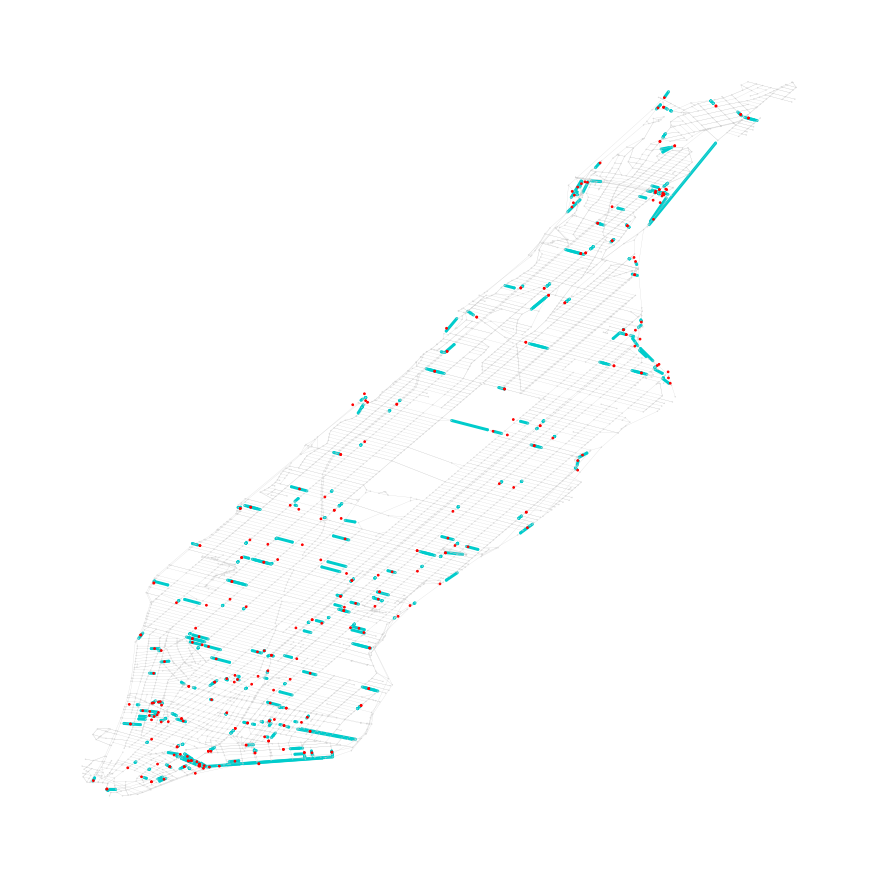

In [4]:
G = nx.DiGraph(rn.nx_graph)

G.add_nodes_from([station.id for station in rn.stations])

node_pos = {nid : node.location for nid, node in rn.nodes.items()}

node_pos.update({stat.id : stat.location for stat in rn.stations})

node_colors = [(0.8,0.8,0.8)]*len(rn.nodes) + [(1,0,0)]*len(rn.stations)
edge_colors = [(0,0.8,0.8) if edge.station is not None else (0.8,0.8,0.8) for edge in rn.edges.values()]

node_sizes = [0.1]*len(rn.nodes) + [3]*len(rn.stations)
edge_widths = [3 if edge.station is not None else 0.2 for edge in rn.edges.values()]

plt.figure(1,figsize=(12,12))
nx.draw(G, pos=node_pos, node_size=node_sizes, width=edge_widths, arrowsize=1e-3, node_color=node_colors, edge_color=edge_colors)

<h3>3.2 OSM Feature Selection</h3>

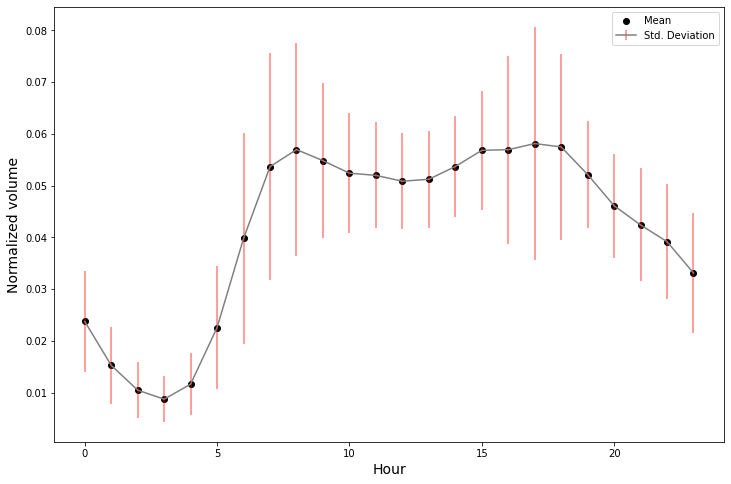

In [5]:
V = np.array([station.volume for station in rn.stations])
V_hat = V / np.sum(V, axis=1).reshape(-1,1)

means = np.mean(V_hat,axis=0)
stds = np.std(V_hat,axis=0)

plt.figure(figsize=(12,8))
plt.errorbar(list(range(24)), means, yerr=stds, ecolor=(1,0,0,0.5), color=(0.5,0.5,0.5), label='Std. Deviation')
plt.scatter(list(range(24)), means, c=[(0,0,0)], label='Mean')
plt.xlabel('Hour',fontsize=14)
plt.ylabel('Normalized volume',fontsize=14)
plt.legend()
plt.show()

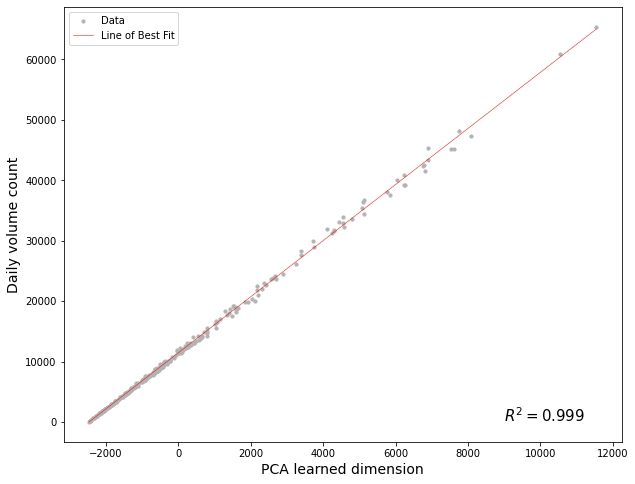

In [6]:
V = np.array([station.volume for station in rn.stations])

pca = PCA(1)

X = pca.fit_transform(V).reshape(-1,1)
y = np.sum(V,axis=1).reshape(-1,1)

reg = LinearRegression().fit(X,y)
m = reg.coef_[0][0]
b = reg.intercept_[0]

def f(x):
    return m*x + b

plt.figure(figsize=(10, 8))
plt.scatter(X, y, s=10, c=[(0.7,0.7,0.7)], label='Data')
plt.plot([min(X), max(X)],[f(min(X)), f(max(X))], c=(1,0,0,1), linewidth=0.5,label='Line of Best Fit')
plt.text(9000,1,r'$R^{2} = ' + str(round(1000 * reg.score(X,y)) / 1000) + '$', size=15)
plt.xlabel('PCA learned dimension',fontsize=14)
plt.ylabel('Daily volume count',fontsize=14)
plt.legend()
plt.show()

<h4>OSM Feature 1: GPS Coordinate</h4>

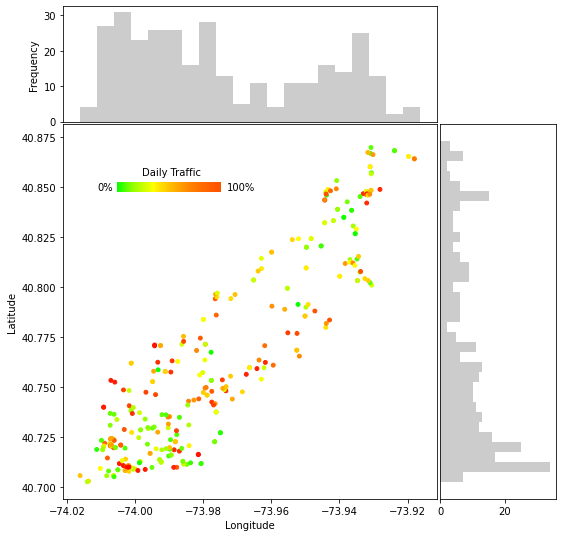

In [7]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    colors = [rn.get_color(round(np.mean(station.volume))) for station in rn.stations]
    ax.scatter(x, y, c=colors, s=15)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    colorbar_x = np.linspace(-74.005, -73.975, 1000)
    colorbar_y = [40.85] * 1000
    
    colorbar_colors = [rn.get_color(round(i / 1.2)) for i in range(1000)]
    
    ax.scatter(colorbar_x, colorbar_y, c=colorbar_colors, marker='|', s=100)
    
    ax.text(-74.011,40.8485,'0%')
    ax.text(-73.973,40.8485,'100%')
    ax.text(-73.998,40.856,'Daily Traffic')

    binwidth = 0.005

    bins_x = np.arange(np.min(x), np.max(x) + binwidth, binwidth)
    bins_y = np.arange(np.min(y), np.max(y) + binwidth, binwidth)
    
    ax_histx.hist(x, bins=bins_x, color=(0.8,0.8,0.8,1))
    ax_histx.set_ylabel('Frequency')
    ax_histx.get_xaxis().set_visible(False)
    
    ax_histy.hist(y, bins=bins_y, orientation='horizontal', color=(0.8,0.8,0.8,1))
    ax_histy.get_yaxis().set_visible(False)
    
x = [station.edge.location()[0] for station in rn.stations]
y = [station.edge.location()[1] for station in rn.stations]

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()

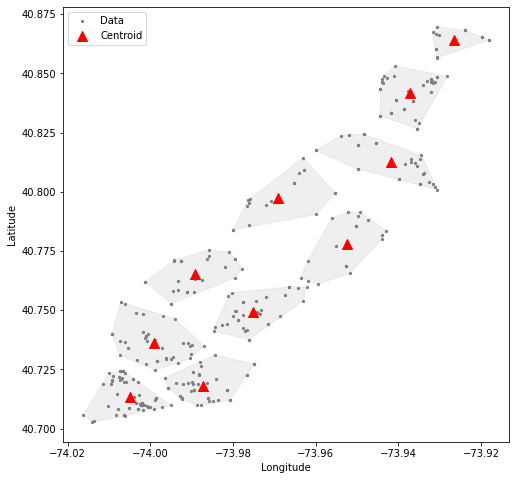

In [8]:
locs = np.array([list(station.edge.location()) for station in rn.stations])
x, y = [x for x, _ in locs], [y for _, y in locs]
kmeans = KMeans(n_clusters=10, random_state=0).fit(locs)
centers = list([tuple(c) for c in kmeans.cluster_centers_])
centers_x, centers_y = [x for x, _ in centers], [y for _, y in centers]

fig = plt.figure(figsize=(8, 8))

for i in range(kmeans.n_clusters):
    
    points = np.array([list(l) for l in locs if kmeans.predict([l])[0] == i])
    
    hull = ConvexHull(points)
    
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    plt.fill(x_hull, y_hull, alpha=0.3, c=(0.8,0.8,0.8,1))

plt.scatter(x,y, s=5, c=[(0.5,0.5,0.5,1)], label='Data')
plt.scatter(centers_x, centers_y, marker='^', s=100, c=[(1,0,0,1)], label='Centroid')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()

plt.show()

<h4>OSM Feature 2: Road Length</h4>

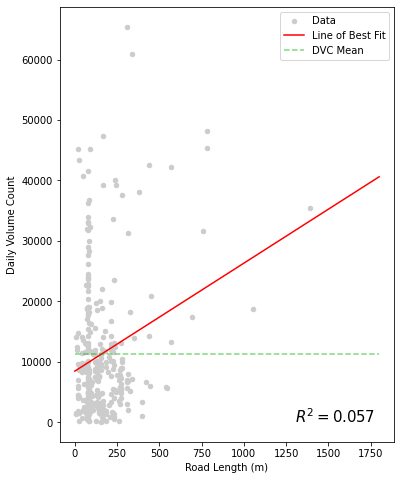

In [9]:
upper_lim = 2000

lengths = [station.edge.distance for station in rn.stations if station.edge.distance < upper_lim]
vols = [np.sum(station.volume) for station in rn.stations if station.edge.distance < upper_lim]

X = np.array([[l] for l in lengths])
y = np.array([[v] for v in vols])

reg = LinearRegression().fit(X,y)

m = reg.coef_[0][0]

b = reg.intercept_


fig = plt.figure(figsize=(6, 8))

plt.scatter(lengths, vols, s=20, c=[(0.8,0.8,0.8,1)], label='Data')
plt.xlabel('Road Length (m)')
plt.ylabel('Daily Volume Count')

plt.plot([0,1800],[b, m*1800 + b], c=(1,0,0,1), label='Line of Best Fit')

plt.plot([0,1800],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')

plt.text(1300,1,r'$R^{2} = ' + str(round(1000 * reg.score(X,y)) / 1000) + '$', size=15)

plt.legend()

plt.show()

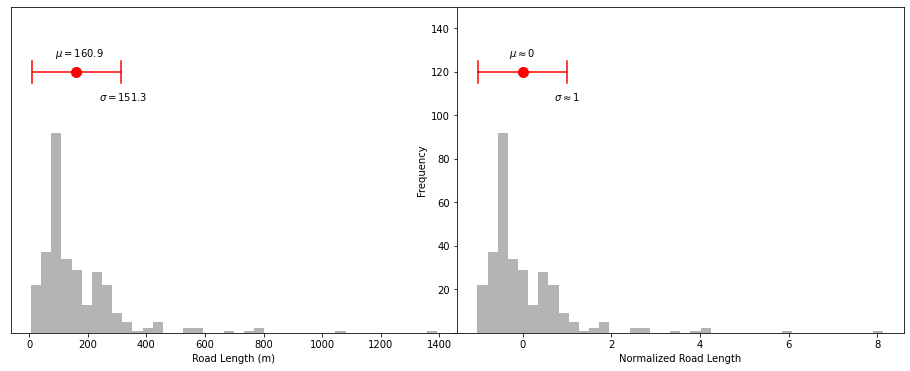

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].hist(lengths, bins=40, color=(0.7,0.7,0.7,1))
axs[0].set_ylim([0,150])
axs[0].get_yaxis().set_visible(False)
mean, std = np.mean(lengths), np.std(lengths)
axs[0].scatter([mean], [120], c=[(1,0,0,1)], s=100)
axs[0].plot([mean - std, mean + std], [120, 120], c=(1,0,0,1))
axs[0].plot([mean - std, mean - std], [115, 125], c=(1,0,0,1))
axs[0].plot([mean + std, mean + std], [115, 125], c=(1,0,0,1))
axs[0].text(90,127,r'$\mu = ' + str(round(10 * mean) / 10) + '$')
axs[0].text(240,107,r'$\sigma = ' + str(round(10 * std) / 10) + '$')
axs[0].set_xlabel('Road Length (m)')
axs[1].hist((lengths - np.mean(lengths)) / np.std(lengths), bins=40, color=(0.7,0.7,0.7,1))
axs[1].set_ylim([0,150])
axs[1].yaxis.get_major_ticks()[0].label1.set_visible(False)
axs[1].scatter([0], [120], c=[(1,0,0,1)], s=100)
axs[1].plot([-1, 1], [120, 120], c=(1,0,0,1))
axs[1].plot([-1, -1], [115, 125], c=(1,0,0,1))
axs[1].plot([1, 1], [115, 125], c=(1,0,0,1))
axs[1].text(-0.3,127,r'$\mu \approx 0$')
axs[1].text(0.7,107,r'$\sigma \approx 1$')
axs[1].set_xlabel('Normalized Road Length')
axs[1].set_ylabel('Frequency')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<h4>OSM Feature 3: Speed Limit</h4>

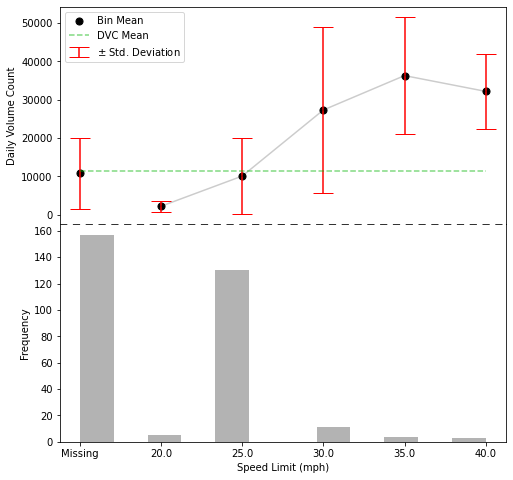

In [11]:
upper_lim = 100
speed_limits = [station.edge.speed_limit if station.edge.speed_limit is not None and station.edge.speed_limit < upper_lim else 15 for station in rn.stations]
vols = [np.sum(station.volume) for station in rn.stations]

fig, axs = plt.subplots(2, 1, figsize=(8,8))

speed_types = sorted(list(set(speed_limits)))

vol_means = []
vol_stds = []

for speed in speed_types:
    speed_vols = [v for v, s in zip(vols, speed_limits) if s == speed]
    vol_means.append(np.mean(speed_vols))
    vol_stds.append(np.std(speed_vols))

axs[0].errorbar(speed_types, vol_means, yerr=vol_stds, capsize=10, color=(0,0,0,0), ecolor='red', label=r'$\pm$ Std. Deviation')
axs[0].plot(speed_types[1:], vol_means[1:], color=(0,0,0,0.2))
axs[0].scatter(speed_types, vol_means, c=[(0,0,0,1)], s=50, label='Bin Mean')
axs[0].plot([15,40],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')
axs[0].set_ylabel('Daily Volume Count')
axs[0].get_xaxis().set_visible(False)
axs[0].legend()

axs[1].hist(speed_limits, bins=12, color=(0.7,0.7,0.7,1))
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Speed Limit (mph)')
axs[1].spines['top'].set_linestyle((0,(8,8)))

xticks = list(axs[1].get_xticks())[1:-1]
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(['Missing'] + xticks[1:])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<h4>OSM Feature 4: Number of Lanes</h4>

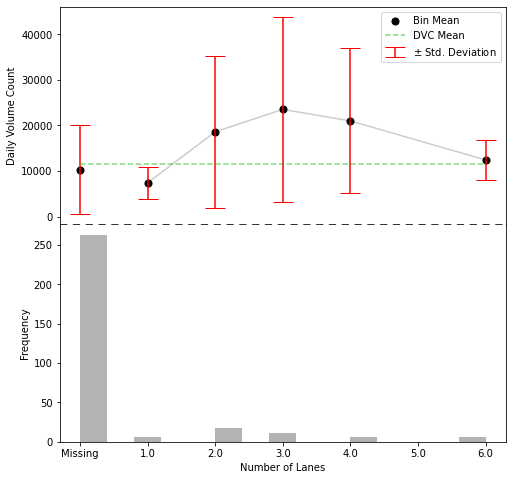

In [12]:
lanes = [station.edge.lanes if station.edge.lanes is not None else 0 for station in rn.stations]
vols = [np.sum(station.volume) for station in rn.stations]

fig, axs = plt.subplots(2, 1, figsize=(8,8))

lane_types = sorted(list(set(lanes)))

vol_means = []
vol_stds = []

for lane in lane_types:
    lane_vols = [v for v, l in zip(vols, lanes) if l == lane]
    vol_means.append(np.mean(lane_vols))
    vol_stds.append(np.std(lane_vols))

axs[0].errorbar(lane_types, vol_means, yerr=vol_stds, capsize=10, color=(0,0,0,0), ecolor='red', label=r'$\pm$ Std. Deviation')
axs[0].plot(lane_types[1:], vol_means[1:], color=(0,0,0,0.2))
axs[0].scatter(lane_types, vol_means, c=[(0,0,0,1)], s=50, label='Bin Mean')
axs[0].plot([0,6],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')
axs[0].set_ylabel('Daily Volume Count')
axs[0].get_xaxis().set_visible(False)
axs[0].legend()

axs[1].hist(lanes, bins=15, color=(0.7,0.7,0.7,1))
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Number of Lanes')
axs[1].spines['top'].set_linestyle((0,(8,8)))

xticks = list(axs[1].get_xticks())[1:-1]
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(['Missing'] + xticks[1:])


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<h3>3.3 Feature Engineering</h3>

<h4>Engineered Feature 1: Direction</h4>

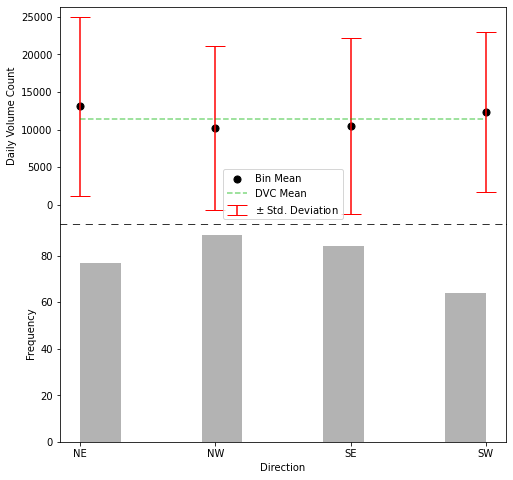

In [13]:
def direct_str(direct):
    hor, ver = direct
    return ver + hor

directs = [direct_str(station.edge.direction) for station in rn.stations]
vols = [np.sum(station.volume) for station in rn.stations]

fig, axs = plt.subplots(2, 1, figsize=(8,8))

direct_types = sorted(list(set(directs)))

vol_means = []
vol_stds = []

for direct in direct_types:
    direct_vols = [v for v, d in zip(vols, directs) if d == direct]
    vol_means.append(np.mean(direct_vols))
    vol_stds.append(np.std(direct_vols))

axs[0].errorbar(direct_types, vol_means, yerr=vol_stds, capsize=10, color=(0,0,0,0), ecolor='red', label=r'$\pm$ Std. Deviation')
axs[0].scatter(direct_types, vol_means, c=[(0,0,0,1)], s=50, label='Bin Mean')
axs[0].plot(['NE', 'SW'],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')
axs[0].set_ylabel('Daily Volume Count')
axs[0].get_xaxis().set_visible(False)
axs[0].legend()

axs[1].hist(direct_types + directs, bins=10, color=(0.7,0.7,0.7,1), rwidth=1)
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Direction')
axs[1].spines['top'].set_linestyle((0,(8,8)))


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<h4>Engineered Feature 2: Arctan</h4>

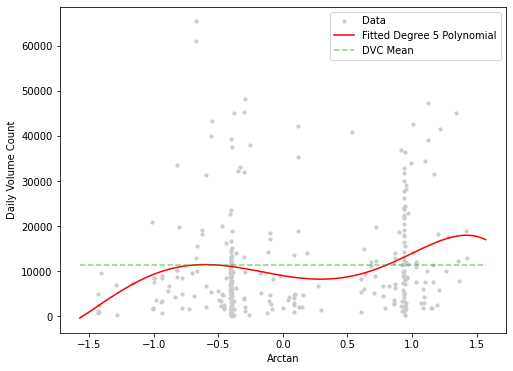

In [14]:
arctans = [station.edge.arctan() for station in rn.stations]
vols = [np.sum(station.volume) for station in rn.stations]

degree = 5
P = np.poly1d(np.polyfit(arctans, vols, degree))
x = np.linspace(-np.pi/2, np.pi/2, 100)

plt.figure(figsize=(8, 6))

plt.scatter(arctans, vols, c=[(0.8,0.8,0.8,1)], s=10, label='Data')
plt.plot(x, P(x), color='red', label='Fitted Degree ' + str(degree) + ' Polynomial')
plt.plot([-np.pi/2,np.pi/2],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')

plt.xlabel('Arctan')
plt.ylabel('Daily Volume Count')

plt.legend()
plt.show()

<h4>Engineered Feature 3: Speed Limit $\div$ Road Length</h4>

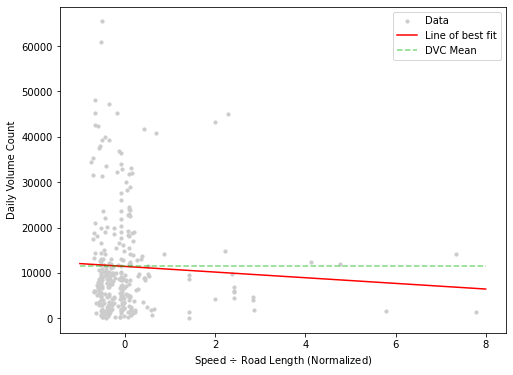

In [15]:
speed_dists = np.array([station.edge.speed_div_dist() for station in rn.stations])
speed_dists = (speed_dists - np.mean(speed_dists)) / np.std(speed_dists)
vols = [np.sum(station.volume) for station in rn.stations]

degree = 1
P = np.poly1d(np.polyfit(speed_dists, vols, degree))
x = np.linspace(-1, 8, 100)

plt.figure(figsize=(8, 6))

plt.scatter(speed_dists, vols, c=[(0.8,0.8,0.8,1)], s=10, label='Data')
plt.plot(x, P(x), color='red', label='Line of best fit')
plt.plot([-1,8],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')

plt.xlabel(r'Speed $\div$ Road Length (Normalized)')
plt.ylabel('Daily Volume Count')

plt.legend()
plt.show()

<h4>Engineered Feature 4: Road Length $\times$ Number of Lanes</h4>

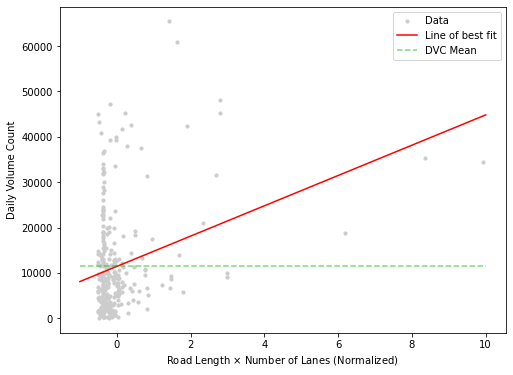

In [16]:
dist_lanes = np.array([station.edge.dist_times_lanes() for station in rn.stations])
dist_lanes = (dist_lanes - np.mean(dist_lanes)) / np.std(dist_lanes)
vols = [np.sum(station.volume) for station in rn.stations]

degree = 1
P = np.poly1d(np.polyfit(dist_lanes, vols, degree))
x = np.linspace(-1, 10, 100)

plt.figure(figsize=(8, 6))

plt.scatter(dist_lanes, vols, c=[(0.8,0.8,0.8,1)], s=10, label='Data')
plt.plot(x, P(x), color='red', label='Line of best fit')
plt.plot([-1,10],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')

plt.xlabel(r'Road Length $\times$ Number of Lanes (Normalized)')
plt.ylabel('Daily Volume Count')

plt.legend()
plt.show()

<h4>Engineered Feature 5: In-Degree</h4>

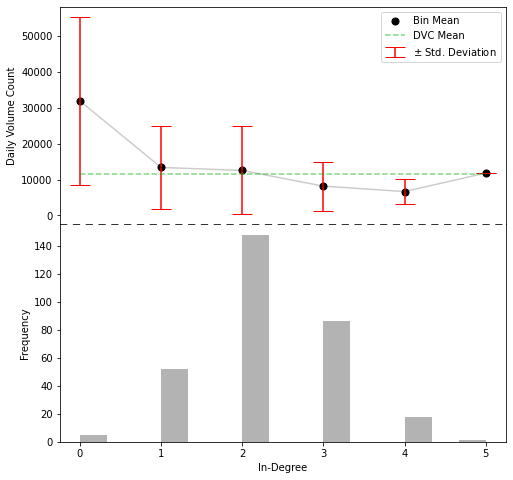

In [17]:
degrees = [station.edge.in_deg for station in rn.stations]
vols = [np.sum(station.volume) for station in rn.stations]

fig, axs = plt.subplots(2, 1, figsize=(8,8))

deg_types = sorted(list(set(degrees)))

vol_means = []
vol_stds = []

for deg in deg_types:
    deg_vols = [v for v, d in zip(vols, degrees) if d == deg]
    vol_means.append(np.mean(deg_vols))
    vol_stds.append(np.std(deg_vols))

axs[0].errorbar(deg_types, vol_means, yerr=vol_stds, capsize=10, color=(0,0,0,0), ecolor='red', label=r'$\pm$ Std. Deviation')
axs[0].plot(deg_types, vol_means, color=(0,0,0,0.2))
axs[0].scatter(deg_types, vol_means, c=[(0,0,0,1)], s=50, label='Bin Mean')
axs[0].plot([0,5],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')
axs[0].set_ylabel('Daily Volume Count')
axs[0].get_xaxis().set_visible(False)
axs[0].legend()

axs[1].hist(degrees, bins=15, color=(0.7,0.7,0.7,1), rwidth=1)
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('In-Degree')
axs[1].spines['top'].set_linestyle((0,(8,8)))


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<h4>Engineered Feature 6: Out-Degree</h4>

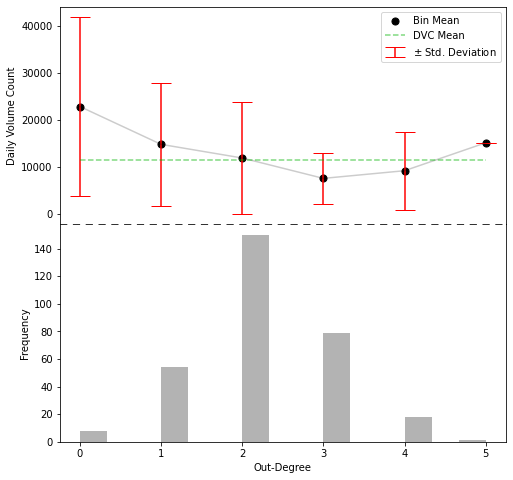

In [18]:
degrees = [station.edge.out_deg for station in rn.stations]
vols = [np.sum(station.volume) for station in rn.stations]

fig, axs = plt.subplots(2, 1, figsize=(8,8))

deg_types = sorted(list(set(degrees)))

vol_means = []
vol_stds = []

for deg in deg_types:
    deg_vols = [v for v, d in zip(vols, degrees) if d == deg]
    vol_means.append(np.mean(deg_vols))
    vol_stds.append(np.std(deg_vols))

axs[0].errorbar(deg_types, vol_means, yerr=vol_stds, capsize=10, color=(0,0,0,0), ecolor='red', label=r'$\pm$ Std. Deviation')
axs[0].plot(deg_types, vol_means, color=(0,0,0,0.2))
axs[0].scatter(deg_types, vol_means, c=[(0,0,0,1)], s=50, label='Bin Mean')
axs[0].plot([0,5],[np.mean(vols)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')
axs[0].set_ylabel('Daily Volume Count')
axs[0].get_xaxis().set_visible(False)
axs[0].legend()

axs[1].hist(degrees, bins=15, color=(0.7,0.7,0.7,1), rwidth=1)
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Out-Degree')
axs[1].spines['top'].set_linestyle((0,(8,8)))


plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<h4>Engineered Feature 7: Betweeenness Centrality</h4>

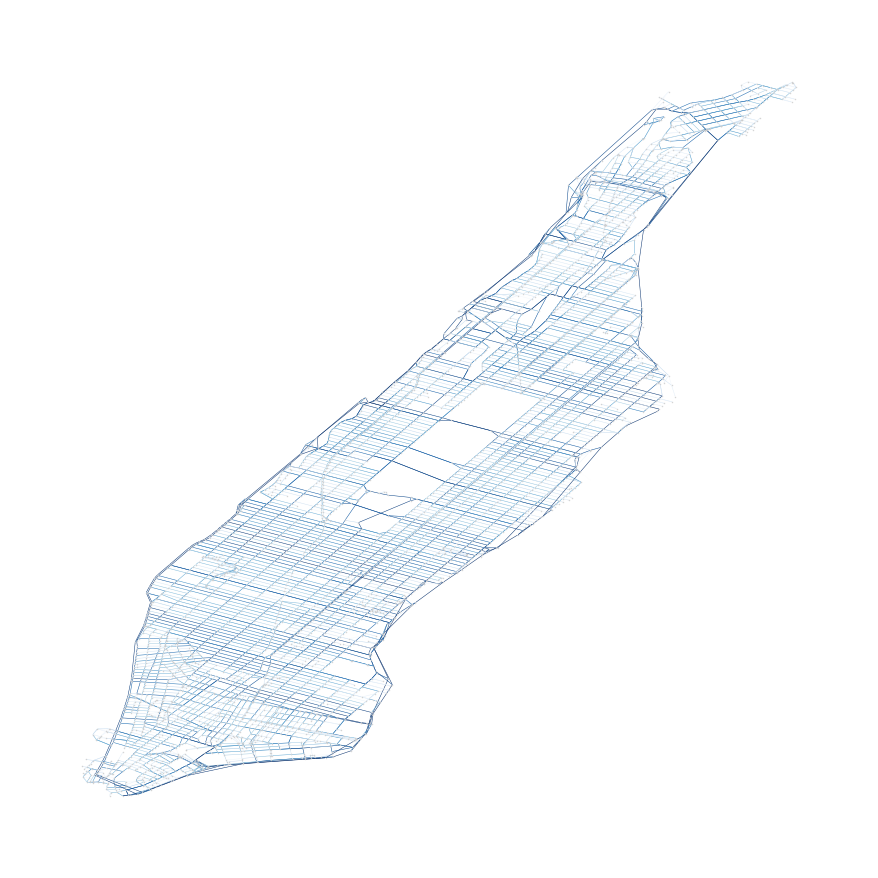

In [19]:
cmap = plt.get_cmap('Blues')

bts = sorted([edge.betweenness for edge in rn.edges.values()])

def get_c(bt):
    return cmap(bts.index(bt) / len(bts))

edge_colors = [get_c(edge.betweenness) for edge in rn.edges.values()]

node_pos = {nid : node.location for nid, node in rn.nodes.items()}

plt.figure(1,figsize=(12,12))
nx.draw(rn.nx_graph, pos=node_pos, node_size=0.2, width=0.5, arrowsize=1e-3, node_color=[(0.8,0.8,0.8,1)], edge_color=edge_colors)

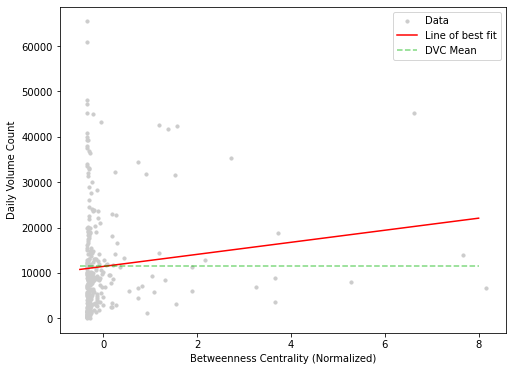

In [20]:
x = np.array([station.edge.betweenness for station in rn.stations])
x = (x - np.mean(x)) / np.std(x)
y = [np.sum(station.volume) for station in rn.stations]

degree = 1
P = np.poly1d(np.polyfit(x,y, degree))
X = np.linspace(-0.5, 8, 100)

plt.figure(figsize=(8, 6))

plt.scatter(x,y, c=[(0.8,0.8,0.8,1)], s=10, label='Data')
plt.plot(X, P(X), color='red', label='Line of best fit')
plt.plot([-0.5,8],[np.mean(y)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')

plt.xlabel('Betweenness Centrality (Normalized)')
plt.ylabel('Daily Volume Count')

plt.legend()
plt.show()

<h4>Engineered Feature 8: Closeness Centrality</h4>

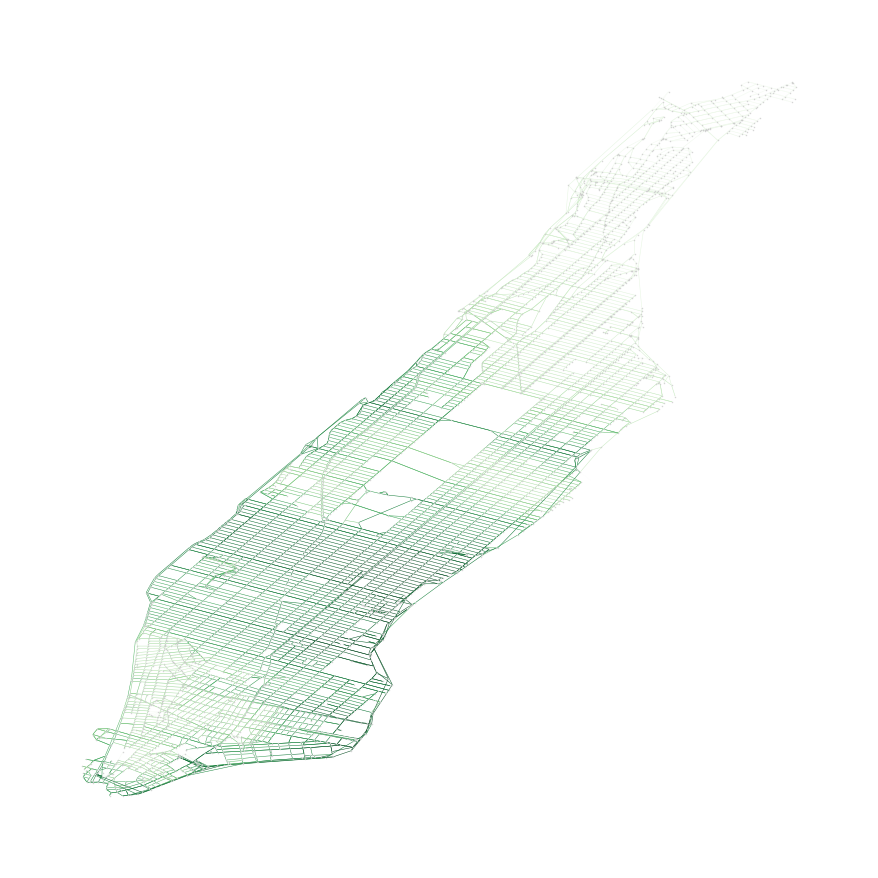

In [21]:
cmap = plt.get_cmap('Greens')

bts = sorted([edge.nodes[0].closeness for edge in rn.edges.values()])

def get_c(bt):
    return cmap(bts.index(bt) / len(bts))

edge_colors = [get_c(edge.nodes[0].closeness) for edge in rn.edges.values()]

node_pos = {nid : node.location for nid, node in rn.nodes.items()}

plt.figure(1,figsize=(12,12))
nx.draw(rn.nx_graph, pos=node_pos, node_size=0.2, width=0.5, arrowsize=1e-3, node_color=[(0.8,0.8,0.8,1)], edge_color=edge_colors)

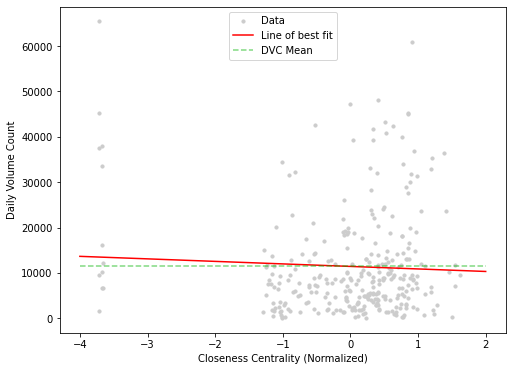

In [22]:
x = np.array([station.edge.nodes[0].closeness for station in rn.stations])
x = (x - np.mean(x)) / np.std(x)
y = [np.sum(station.volume) for station in rn.stations]

degree = 1
P = np.poly1d(np.polyfit(x,y, degree))
X = np.linspace(-4, 2, 100)

plt.figure(figsize=(8, 6))

plt.scatter(x,y, c=[(0.8,0.8,0.8,1)], s=10, label='Data')
plt.plot(X, P(X), color='red', label='Line of best fit')
plt.plot([-4,2],[np.mean(y)] * 2, c=(0,0.7,0,0.5), label='DVC Mean', linestyle='--')

plt.xlabel('Closeness Centrality (Normalized)')
plt.ylabel('Daily Volume Count')

plt.legend()
plt.show()

<h2>4. Predictive Modeling</h2>

<h3>4.1 Performance Metric</h3>

In [23]:
dataset = Dataset([ (data_make_feature(station.edge, 'simple'), station.volume)
                            for station in rn.stations])

data_preprocess(dataset, 'simple')

mean_losses = [dataset.baseline_loss(type='mean', index=i) for i in range(10)] 
median_losses = [dataset.baseline_loss(type='median', index=i) for i in range(10)]

print('Mean Baseline Loss:', np.mean(mean_losses), '±', np.std(mean_losses))
print('Median Baseline Loss:', np.mean(median_losses), '±', np.std(median_losses))

Mean Baseline Loss: 353.92882385253904 ± 56.454408615113564
Median Baseline Loss: 325.86316986083983 ± 57.08049381984826


<h3>4.2 K-Nearest Neighbors</h3>

<h4>Hyperparameter Search</h4>

In [24]:
"""
knn_model = KNearestNeighbors(rn)

k_space = list(range(1,21)) + list(range(25,105,5))

knn_model.validation_curve(k_space, 'knn_example')
"""

"\nknn_model = KNearestNeighbors(rn)\n\nk_space = list(range(1,21)) + list(range(25,105,5))\n\nknn_model.validation_curve(k_space, 'knn_example')\n"

<h4>Results</h4>

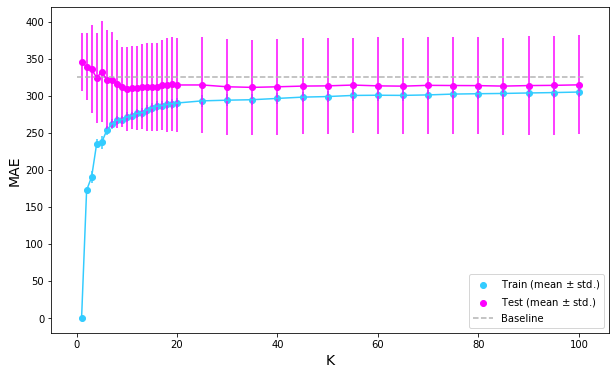

In [26]:
with open('results/knn_final', 'r') as f:
    rd = eval(f.read())

cool = plt.get_cmap('cool')

colors = cool(np.array([0.2, 0.99]))

plt.figure(figsize=(10,6))

losses = rd['losses']
    
x = rd['K_range']
    
plt.errorbar(x, losses['train']['mean'], yerr=losses['train']['std'], color=colors[0])
plt.scatter(x, losses['train']['mean'], label=r'Train (mean $\pm$ std.)', c=[colors[0]])
plt.errorbar(x, losses['test']['mean'], yerr=losses['test']['std'], color=colors[1])
plt.scatter(x, losses['test']['mean'], label=r'Test (mean $\pm$ std.)', c=[colors[1]])
plt.plot([0,101], [rd['baseline']] * 2, color=(0.7,0.7,0.7), linestyle='dashed', label='Baseline')

plt.xlabel('K', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.legend(loc='lower right')
plt.show()

<h3>4.3 Decision Tree</h3>

<h4>Hyperparameter Search</h4>

In [27]:
"""
dt_model = DecisionTree(rn, 'simple')

param_ranges = {
    'max_features' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'max_depth' : list(range(2,15))
}

dt_model.validation_curve(param_ranges, False, 'dt_example')
"""

"\ndt_model = DecisionTree(rn, 'simple')\n\nparam_ranges = {\n    'max_features' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\n    'max_depth' : list(range(2,15))\n}\n\ndt_model.validation_curve(param_ranges, False, 'dt_example')\n"

<h4>Results</h4>

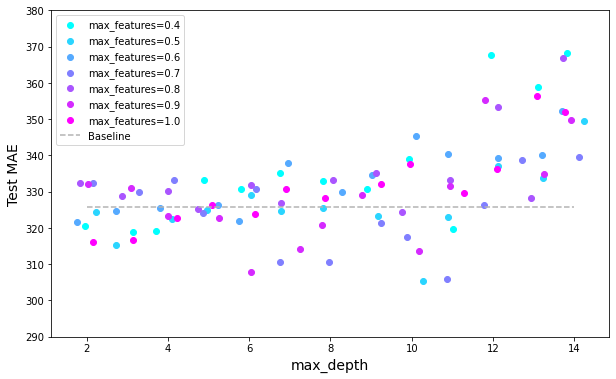

In [28]:
with open('results/dt_final', 'r') as f:
    rd = eval(f.read())

param1, param2 = list(rd.keys())[1], list(rd.keys())[2]
p1_range, p2_range = list(rd.values())[1], list(rd.values())[2]
    
labels = [param1 + '=' + str(val) for val in p1_range]

cool = plt.get_cmap('cool')

colors = cool(np.linspace(0,1,len(labels)))

plt.figure(figsize=(10,6))

for label, color, losses in zip(labels, colors, rd['losses']):
    
    x = p2_range + 0.6*np.random.rand(len(p2_range)) - 0.3
    plt.scatter(x, losses['test']['mean'], label=label, color=[color])

plt.plot([2,14], [rd['baseline']] * 2, color=(0.7,0.7,0.7), linestyle='dashed', label='Baseline')

plt.xlabel('max_depth', fontsize=14)
plt.ylabel('Test MAE', fontsize=14)
plt.ylim([290,380])
plt.legend()
plt.show()

<h3>4.4 Random Forest</h3>

<h4>Hyperparameter Search</h4>

In [29]:
"""
rf_model = DecisionTree(rn, 'simple')

param_ranges = {
    'max_depth' : [2, 4, 6, 8, 10],
    'n_estimators' : [2, 5, 10, 20, 50, 100, 150, 200],
}

rf_model.validation_curve(param_ranges, True, 'rf_example')
"""

"\nrf_model = DecisionTree(rn, 'simple')\n\nparam_ranges = {\n    'max_depth' : [2, 4, 6, 8, 10],\n    'n_estimators' : [2, 5, 10, 20, 50, 100, 150, 200],\n}\n\nrf_model.validation_curve(param_ranges, True, 'rf_example')\n"

<h4>Results</h4>

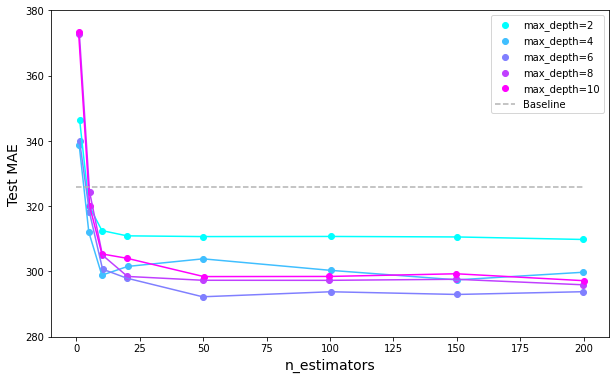

In [30]:
with open('results/rf_final', 'r') as f:
    rd = eval(f.read())

param1, param2 = list(rd.keys())[1], list(rd.keys())[2]
p1_range, p2_range = list(rd.values())[1], list(rd.values())[2]
    
labels = [param1 + '=' + str(val) for val in p1_range]

cool = plt.get_cmap('cool')

colors = cool(np.linspace(0,1,len(labels)))

plt.figure(figsize=(10,6))

for label, color, losses in zip(labels, colors, rd['losses']):
    
    x = p2_range + 0.6*np.random.rand(len(p2_range)) - 0.3
    plt.plot(x, losses['test']['mean'], color=color)
    plt.scatter(x, losses['test']['mean'], label=label, color=[color])

plt.plot([0,200], [rd['baseline']] * 2, color=(0.7,0.7,0.7), linestyle='dashed', label='Baseline')

plt.xlabel('n_estimators', fontsize=14)
plt.ylabel('Test MAE', fontsize=14)
plt.ylim([280,380])
plt.legend()
plt.show()

<h4>Feature Importance</h4>

Testing...
Baseline Loss: 404.8790283203125
Train Loss: 209.14604390681004
Test Loss: 333.12540322580645


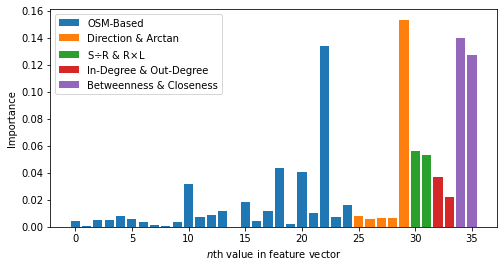

In [31]:
rf = DecisionTree(rn, 'simple')
rf.train(ensemble=True, n_estimators=50, max_depth=6)

plt.figure(figsize=(8,4))
plt.bar(list(range(25)), rf.model.feature_importances_[:25], label='OSM-Based')
plt.bar(list(range(25,30)), rf.model.feature_importances_[25:30], label='Direction & Arctan')
plt.bar(list(range(30,32)), rf.model.feature_importances_[30:32], label=r'S$\div$R & R$\times$L')
plt.bar(list(range(32,34)), rf.model.feature_importances_[32:34], label='In-Degree & Out-Degree')
plt.bar(list(range(34,36)), rf.model.feature_importances_[34:36], label='Betweenness & Closeness')
plt.legend()
plt.xlabel(r'$n$th value in feature vector')
plt.ylabel('Importance')
plt.show()

<h3>4.5 Neural Network</h3>

<h4>Hyperparameter Search</h4>

In [32]:
"""
nn_model = NeuralNet(rn, 'simple')

lr_range = [1e-5, 2e-5, 5e-5, 1e-4]
hl_range = [0, 1, 2, 5, 10, 15, 20]

nn_model.validation_curve(lr_range, hl_range, 'nn_example')
"""

"\nnn_model = NeuralNet(rn, 'simple')\n\nlr_range = [1e-5, 2e-5, 5e-5, 1e-4]\nhl_range = [0, 1, 2, 5, 10, 15, 20]\n\nnn_model.validation_curve(lr_range, hl_range, 'nn_example')\n"

<h4>Results</h4>

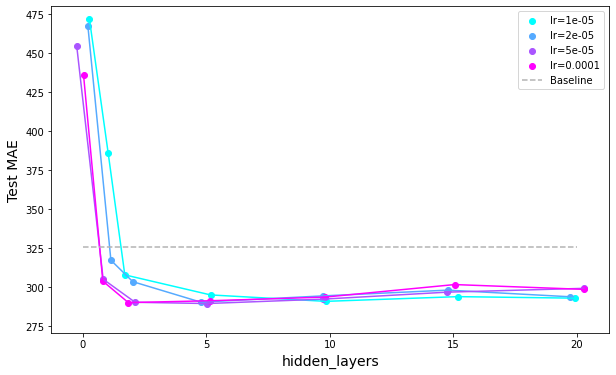

In [33]:
with open('results/nn_final', 'r') as f:
    rd = eval(f.read())

param1, param2 = list(rd.keys())[1], list(rd.keys())[2]
p1_range, p2_range = list(rd.values())[1], list(rd.values())[2]
    
labels = [param1 + '=' + str(val) for val in p1_range]

cool = plt.get_cmap('cool')

colors = cool(np.linspace(0,1,len(labels)))

plt.figure(figsize=(10,6))

for label, color, losses in zip(labels, colors, rd['losses']):
    
    x = p2_range + 0.6*np.random.rand(len(p2_range)) - 0.3
    plt.plot(x, losses['test']['mean'], color=color)
    plt.scatter(x, losses['test']['mean'], label=label, color=[color])

plt.plot([0,20], [rd['baseline']] * 2, color=(0.7,0.7,0.7), linestyle='dashed', label='Baseline')

plt.xlabel('hidden_layers', fontsize=14)
plt.ylabel('Test MAE', fontsize=14)
plt.ylim([271,480])
plt.legend()
plt.show()

<h4>Feature Importance</h4>

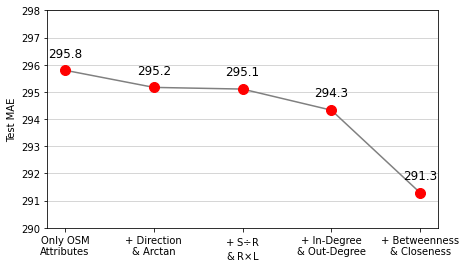

In [34]:
atts = ['Only OSM\nAttributes', '+ Direction\n& Arctan', r'+ S$\div$R' +'\n'+ r'& R$\times$L',
        '+ In-Degree\n& Out-Degree', '+ Betweenness\n& Closeness']

errors = []
stds = []

for x in ['', '+eng1', '+eng1+2', '+eng1+2+3', '+eng1+2+3+4']:
 
    with open('results/nn_just_osm' + x, 'r') as f:
        results_dict = eval(f.read())
        errors.append(results_dict['losses'][0]['test']['mean'][0])
        stds.append(results_dict['losses'][0]['test']['std'][0])
        
def round1(x):
    return str(round(10 * x) / 10)

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.5, round1(y[i]), ha = 'center', fontsize=12)
    
plt.figure(figsize=(7,4))
plt.plot(atts, errors, color='grey')#, width=0.5)
plt.scatter(atts, errors, s=100, c='red', zorder=10)
plt.ylim([290, 298])
plt.ylabel('Test MAE')
plt.grid(axis="y", color=(0.8,0.8,0.8))

addlabels(atts, errors)

plt.show()

<h4>Train/Test loss over time without early stopping</h4>

In [35]:
net = NeuralNet(rn, 'simple')
results = net.train(early_stopping=False, hidden_layers=5, lr=5e-5)

Epoch 100
---------
Train loss: 480.0716552734375
Baseline loss: 232.2069854736328
Test loss: 357.6575927734375
---------
Epoch 200
---------
Train loss: 327.6684265136719
Baseline loss: 232.2069854736328
Test loss: 231.11277770996094
---------
Epoch 300
---------
Train loss: 307.23223876953125
Baseline loss: 232.2069854736328
Test loss: 209.42405700683594
---------
Epoch 400
---------
Train loss: 297.61370849609375
Baseline loss: 232.2069854736328
Test loss: 202.68470764160156
---------
Epoch 500
---------
Train loss: 294.5537414550781
Baseline loss: 232.2069854736328
Test loss: 197.20004272460938
---------
Epoch 600
---------
Train loss: 295.0979309082031
Baseline loss: 232.2069854736328
Test loss: 192.79736328125
---------
Epoch 700
---------
Train loss: 290.48126220703125
Baseline loss: 232.2069854736328
Test loss: 188.67063903808594
---------
Epoch 800
---------
Train loss: 286.8984680175781
Baseline loss: 232.2069854736328
Test loss: 185.42941284179688
---------
Epoch 900
-------

Epoch 6800
---------
Train loss: 143.46994018554688
Baseline loss: 232.2069854736328
Test loss: 267.03228759765625
---------
Epoch 6900
---------
Train loss: 140.934814453125
Baseline loss: 232.2069854736328
Test loss: 270.2876892089844
---------
Epoch 7000
---------
Train loss: 138.77169799804688
Baseline loss: 232.2069854736328
Test loss: 272.6159362792969
---------
Epoch 7100
---------
Train loss: 137.40423583984375
Baseline loss: 232.2069854736328
Test loss: 273.4387512207031
---------
Epoch 7200
---------
Train loss: 136.0417022705078
Baseline loss: 232.2069854736328
Test loss: 275.8077697753906
---------
Epoch 7300
---------
Train loss: 134.16873168945312
Baseline loss: 232.2069854736328
Test loss: 276.6298522949219
---------
Epoch 7400
---------
Train loss: 132.81678771972656
Baseline loss: 232.2069854736328
Test loss: 277.8656005859375
---------
Epoch 7500
---------
Train loss: 130.94923400878906
Baseline loss: 232.2069854736328
Test loss: 279.8003234863281
---------
Epoch 7600

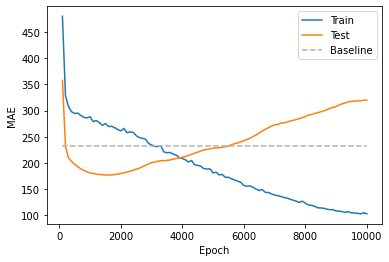

In [36]:
plt.plot(results['epochs'], results['train_history'], label='Train')
plt.plot(results['epochs'], results['test_history'], label='Test')
plt.plot([results['epochs'][0], results['epochs'][-1]], [results['baseline_loss']]*2, color=(0.7,0.7,0.7), linestyle='dashed', label='Baseline')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

<h2>5. Model Evaluation & Discussion</h2>

<h3>5.1 Model Trustworthiness</h3>

In [38]:
locs = np.array([list(edge.location()) for edge in rn.edges.values()])
kmeans = KMeans(n_clusters=5, random_state=0).fit(locs)

def get_3bins(data):
    mean, std = np.mean(data), np.std(data)
    return [(-np.inf, mean - std), (mean - std, mean + std), (mean + std, np.inf)]

def range_index(val, ranges):
    for i, rang in enumerate(ranges):  
        try:
            start, end = rang
            if start <= val and val < end:
                return i
        except:
            if val == rang:
                return i
    return None

bin_info = {
    'location' : (lambda e: kmeans.predict([list(e.location())])[0], list(range(5))),
    'length' : (lambda e: e.distance, get_3bins([edge.distance for edge in rn.edges.values()])),
    'direction' : (lambda e: e.direction[1] + e.direction[0], ['NE', 'NW', 'SE', 'SW']),
    'speed' : (lambda e: e.speed_limit, [None, (0, 21), (21, 28), (28, np.inf)]),
    'lanes' : (lambda e: e.lanes, [None, (0.5, 2.5), (2.5, 4.5), (4.5, np.inf)]),
    'betweenness' : (lambda e: e.betweenness, get_3bins([edge.betweenness for edge in rn.edges.values()])),
    'closeness' : (lambda e: e.nodes[0].closeness, get_3bins([edge.nodes[0].closeness for edge in rn.edges.values()])),
    'degrees' : (lambda e: e.in_deg + e.out_deg, [(0.5,3.5), (3.5, 5.5), (5.5,np.inf)])
}

bin_types = list(itertools.product(*[list(range(len(rang))) for _, (_, rang) in bin_info.items()]))

In [39]:
def get_P(edges):

    bins = {bt : 0 for bt in bin_types}

    for edge in edges:
        encoding = tuple([range_index(fn(edge), ranges) for _, (fn, ranges) in bin_info.items()])
        bins[encoding] += 1
    
    P = np.array(list(bins.values()))
    
    return P / np.sum(P)

def kl_div(P,Q):
    P, Q = np.clip(P, 1e-10, 1 - 1e-10), np.clip(Q, 1e-10, 1 - 1e-10)
    return np.sum(P * np.log(P) - P * np.log(Q))

P_all = get_P(rn.edges.values())

In [40]:
N = 10000

kls = []

for i in range(N):
    
    bin_indices = np.random.choice(list(range(len(bin_types))), 310, p=P_all)
    
    P_i = np.zeros(len(bin_types))
    
    for bi in bin_indices:
        P_i[bi] += 1
    
    P_i = P_i / np.sum(P_i)
    
    kls.append(kl_div(P_all, P_i))

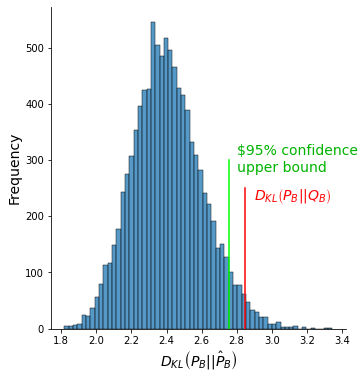

In [41]:
test_stat = kl_div(P_all, get_P([stat.edge for stat in rn.stations]))
cutoff = np.sort(kls)[int(0.95 * len(kls))]

sns.displot(kls)
plt.plot([test_stat]*2, [0,250], color='red')
plt.plot([cutoff]*2, [0,300], color=(0,1,0))
plt.xlabel(r'$D_{KL}\left(P_{B} || \hat{P}_{B} \right)$', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.text(2.9,230,r'$D_{KL}\left(P_{B} || Q_{B} \right)$', fontsize=14, color='red')
plt.text(2.8,280,'$95% confidence\nupper bound', fontsize=14, color=(0,0.7,0))
plt.show()

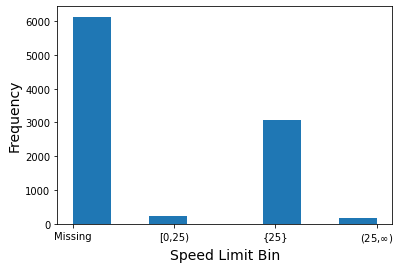

In [42]:
fn, ranges = bin_info['speed']

x = ['Missing', '[0,25)', '{25}', r'(25,$\infty$)']

encodings = [x[range_index(fn(edge), ranges)] for edge in rn.edges.values()]

plt.hist(x + encodings, bins=8)
plt.xlabel('Speed Limit Bin', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()

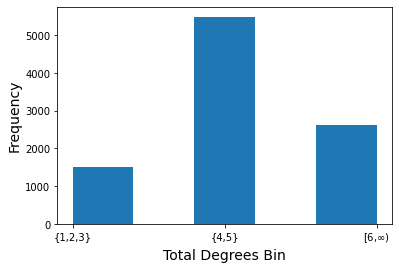

In [43]:
fn, ranges = bin_info['degrees']

x = ['{1,2,3}', '{4,5}', r'[6,$\infty$)']

encodings = [x[range_index(fn(edge), ranges)] for edge in rn.edges.values()]

plt.hist(x + encodings, bins=5)
plt.xlabel('Total Degrees Bin', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

<h3>5.2 Model Performance</h3>

In [44]:
nn_model = NeuralNet(rn, 'simple')
nn_model.train(lr=5e-5, hidden_layers=5)
loss_data = nn_model.test_performance(0)

Epoch 100
---------
Train loss: 452.85894775390625
Baseline loss: 234.3817138671875
Test loss: 349.83233642578125
---------
Epoch 200
---------
Train loss: 319.5526123046875
Baseline loss: 234.3817138671875
Test loss: 232.40994262695312
---------
Epoch 300
---------
Train loss: 303.5260314941406
Baseline loss: 234.3817138671875
Test loss: 225.66482543945312
---------
Epoch 400
---------
Train loss: 298.896484375
Baseline loss: 234.3817138671875
Test loss: 221.15931701660156
---------
Epoch 500
---------
Train loss: 294.8943176269531
Baseline loss: 234.3817138671875
Test loss: 216.88441467285156
---------
Epoch 600
---------
Train loss: 292.5458068847656
Baseline loss: 234.3817138671875
Test loss: 213.36329650878906
---------
Epoch 700
---------
Train loss: 289.1374206542969
Baseline loss: 234.3817138671875
Test loss: 210.29415893554688
---------
Epoch 800
---------
Train loss: 286.6407470703125
Baseline loss: 234.3817138671875
Test loss: 208.2284698486328
---------
Epoch 900
---------


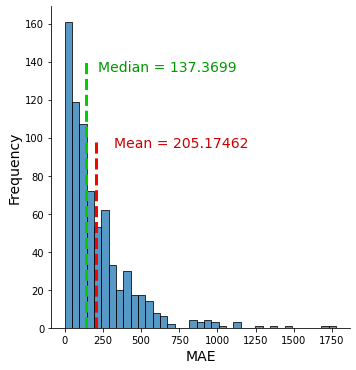

In [45]:
sns.displot(loss_data)
plt.plot([np.mean(loss_data)]*2, [0,100], color=(1,0,0), linewidth=3, linestyle='dashed')
plt.plot([np.median(loss_data)]*2, [0,140], color=(0,0.8,0), linewidth=3, linestyle='dashed')
plt.xlabel('MAE', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.text(320, 95, 'Mean = ' + str(np.mean(loss_data)), color=(0.8,0,0), fontsize=14)
plt.text(220, 135, 'Median = ' + str(np.median(loss_data)), color=(0,0.6,0), fontsize=14)
plt.show()

<h3>5.3 Project Improvements</h3>

In [46]:
bins = {bt : [] for bt in bin_types}

for edge in rn.edges.values():
    encoding = tuple([range_index(fn(edge), ranges) for _, (fn, ranges) in bin_info.items()])
    bins[encoding].append(edge)
    
P_all = np.array([len(b) for b in bins.values()])    
P_all = P_all / np.sum(P_all)

In [47]:
bin_keys = np.random.choice(list(range(len(bin_types))), 500, p=P_all)
sampled_edges = [random.choice(bins[bin_types[bin_key]]) for bin_key in bin_keys]
station_pos = {'S-' + str(edge.id) : tuple(edge.location()) for edge in sampled_edges}

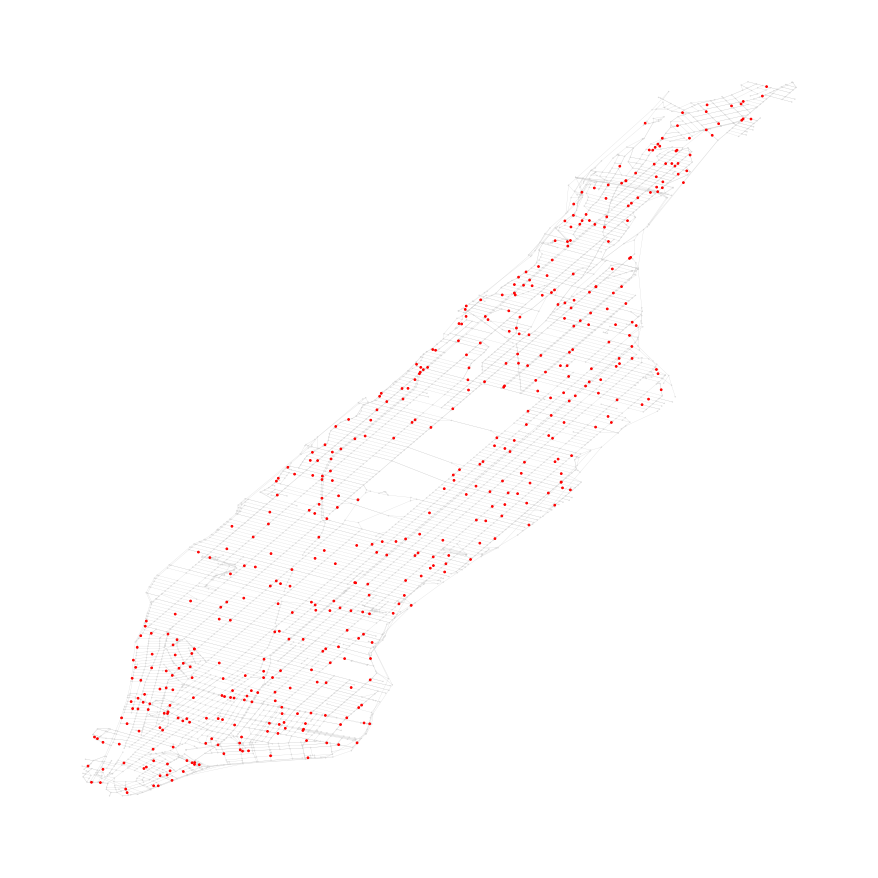

In [48]:
G = nx.DiGraph(rn.nx_graph)

G.add_nodes_from(list(station_pos.keys()))

node_pos = {nid : node.location for nid, node in rn.nodes.items()}

node_pos.update(station_pos)

node_colors = [(0.8,0.8,0.8)]*len(rn.nodes) + [(1,0,0)]*len(station_pos)

node_sizes = [0.1]*len(rn.nodes) + [3]*len(station_pos)

plt.figure(1,figsize=(12,12))
nx.draw(G, pos=node_pos, node_size=node_sizes, width=0.2, arrowsize=1e-3, node_color=node_colors, edge_color=(0.8,0.8,0.8,1))

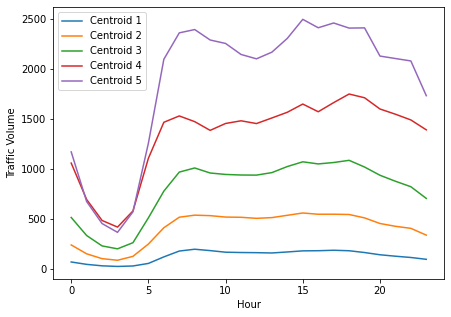

In [49]:
vols = np.array([stat.volume for stat in rn.stations])

plt.figure(figsize=(7,5))

K = 5

kmeans = KMeans(n_clusters=K, random_state=0).fit(vols)

centroids = [kmeans.cluster_centers_[i,:] for i in range(K)]

centroids.sort(key=lambda x: np.sum(x))

for i in range(K):
    plt.plot(list(range(24)), centroids[i], label='Centroid ' + str(i+1))

plt.legend()
plt.ylabel('Traffic Volume')
plt.xlabel('Hour')
plt.show()